# 4.7 Preciso de um espaço (latente) para pensar

**Nome: Joana de Medeiros Oliveira Hulse Molinete**

### Introdução:

Um autocodificador é um tipo de arquitetura de rede neural projetada para compactar (codificar) eficientemente dados de entrada até suas características essenciais e então reconstruir (decodificar) a entrada original a partir dessa representação compactada.

Autocodificadores são treinados para descobrir variáveis latentes dos dados de entrada: variáveis ocultas ou aleatórias que, apesar de não serem diretamente observáveis, informam fundamentalmente a forma como os dados são distribuídos. Coletivamente, as variáveis latentes de um determinado conjunto de dados de entrada são chamadas de espaço latente. Durante o treinamento, o autocodificador aprende quais variáveis latentes podem ser usadas para reconstruir os dados originais com mais precisão: essa representação do espaço latente, portanto, representa apenas as informações mais essenciais contidas na entrada original. Os codificadores descobrem as variáveis latentes ao passar os dados de entrada por um "gargalo" antes de chegarem ao decodificador. Isso força o codificador a aprender a extrair e passar para frente apenas as informações mais importantes para reconstruir a entrada original.

Apesar de não precisarem de validação externa, autoencoders não podem ser classificados como modelos não-supervisionados, já que tem como objetivo a reconstrução da própria entrada, que também servem de comparação para a saída. Por isso, são classificados como modelos autossupervisionados — daí o nome "autocodificador".

### Autoencoders Variacionais:

Autocodificadores variacionais (VAEs) adaptam a arquitetura do autoencoder original para uso em tarefas generativas, onde o decodificador gera novas amostras de dados. Ao invés de reproduzir uma representação direta do espaço latente (como os encoders usuais), produz dois conjuntos de parâmetros: um de médias (μ) e um do logaritmo das variâncias (σ²). A representação latente (z) é amostrada dessa distribuição Gaussiana usando o truque de reparametrização, que separa a parte estocástica da parte determinística do cálculo.
Para gerar uma nova amostra, o VAE amostra um vetor latente aleatório (ε) de dentro da distribuição Gaussiana — basicamente, seleciona um ponto de partida aleatório de dentro da distribuição normal — desloca-o pela média da distribuição latente (μ) e o dimensiona pela variância da distribuição latente (σ).
 
Os VAEs aprendem a codificar aprendizados de recursos importantes a partir das entradas nos conjuntos de dados nos quais são treinados de uma forma flexível e aproximada, o que permite gerar novas amostras que se assemelham aos dados de treinamento originais.

### Importando as bibliotecas necessárias e definindo os hiperparâmetros:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm

entrada = 784 # 28x28 pixels
num_classes = 10 # 0-9
taxa_aprendizado = 0.001
num_epocas = 30
tamanho_lote = 100
hidden_dim = 400 # n° de neurônios ocultos em cada camada
latent_dim = 200 # tamanho do vetor z compactado

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_transform = transforms.Compose([transforms.ToTensor(),])
kwargs = {'num_workers': 1, 'pin_memory': True} # key arguments

dataset_treino = datasets.MNIST(root='dataset/', download=True, train=True, transform=mnist_transform)
carrega_dados_treino = DataLoader(dataset=dataset_treino, batch_size=tamanho_lote, shuffle=True, **kwargs) # aqui **kwargs vai desempacotar o dicionário

dataset_teste = datasets.MNIST(root='dataset/', download=True, train=False, transform=mnist_transform)
carrega_dados_teste = DataLoader(dataset=dataset_teste, batch_size=tamanho_lote, shuffle=True, **kwargs)

### Bloco encoder:

Aqui, definimos a arquitetura da parte codificadora da nossa rede, que recebe as entradas e codifica sua representação nas camadas totalmente conectadas. Usamos a função LeakyReLU ao invés da ReLU, pois ela impede que o gradiente zere quando o neurônio recebe um valor negativo. Precisamos modelar uma distribuição gaussiana N(μ,σ^2), então precisamos de dois vetores de saída: a média e a variância da distribuição. Aqui, trabalhamos com o logaritmo da variância, pois fornece maior estabilidade para a rede.

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        # aplicando camadas lineares para compactar os vetores:
        self.FC_input = nn.Linear(input_dim, hidden_dim) # camada fully-connected que comprime os dados de entrada (vetor de 784 valores) nas camadas ocultas (vetor de 400 valores)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim) # repete o processo da primeira camada fully-connected, mas dessa vez mantendo a dimensão para aumentar a profundidade
    
        self.FC_mean =nn.Linear(hidden_dim, latent_dim) # gera o vetor de médias 
        self.FC_var = nn.Linear(hidden_dim, latent_dim) # gera o logaritmo das variâncias
        
        self.LeakyReLU = nn.LeakyReLU(0.2) # se a entrada for positiva a informação passa igual, se for negativa passa apenas 20% (slope = 0.2)
        
    def forward(self, x):
        z_ = self.LeakyReLU(self.FC_input(x))
        z_ = self.LeakyReLU(self.FC_input2(z_))
        mean = self.FC_mean(z_) # projeta o vetor z (hidden_dim) em um vetor de médias de dimensão latent_dim (200 valores)
        log_var = self.FC_var(z_) # projeta o vetor z (hidden_dim) em um vetor do log-variância de dimensão latent_dim (200 valores)
        
        return mean, log_var    

### Bloco decoder:

Agora que definimos a codificação, vamos definir como funcionará o decodificador, que vai receber como entrada a saída comprimida da camada de amostragem e reconstruir a imagem original tendo como ponto de partida o vetor z.
Para descomprimir os dados, aplicamos uma função sigmoidal em cada componente de x reconstruído, projetando o valor entre 0 e 1, para que a função de perda (Binary Cross-Entropy) possa interpretar como probabilidades futuramente.

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim) # expande a saída do encoder (200 valores) de volta para um vetor de 400 valores
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim) # 400 -> 400 + LeakyReLU
        self.FC_output = nn.Linear(hidden_dim, output_dim) # gera o vetor reconstruído de x (400 -> 784)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        z = self.LeakyReLU(self.FC_hidden(x))
        z = self.LeakyReLU(self.FC_hidden2(z))
        
        x_reconstruido = torch.sigmoid(self.FC_output(z)) # garante que x_reconstruído siga uma distribuição entre 0 e 1
        return x_reconstruido

### Conectando nosso modelo VAE:

Agora que definimos as duas partes principais de uma rede autocodificadora, podemos combiná-las em um modelo completo. Também utilizaremos o truque de reparametrização aqui, permitindo que os gradientes fluam através das operações de amostragem.
Queremos que o vetor z siga uma distribuição normal N(μ,σ²), e que ainda nos permita calcular os gradientes (ou seja, mantendo a diferenciabilidade do modelo). Para isso, aplicamos o truque de reparametrização, que basicamente move a variável aleatória (epsilon) para fora da operação de amostragem da distribuição. Assim, mesmo incorporando um elemento estocástico ainda conseguimos propagar os gradientes dos parâmetros, porque eles não dependem do ruído criado.

In [5]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparametrizacao(self, mean, var):
        epsilon = torch.randn_like(var).to(device) # cria um tensor de ruído com a mesma forma de (var), de onde amostra o epsilon
        z = mean + (var * epsilon) # reparametrização
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var) # transforma a variância em desvio padrão
        z = self.reparametrizacao(mean, std) # aplica a reparametrização
        x_reconstruido = self.Decoder(z)
        return x_reconstruido, mean, log_var

In [6]:
encoder = Encoder(input_dim = entrada, hidden_dim = hidden_dim, latent_dim = latent_dim)
decoder = Decoder(latent_dim = latent_dim, hidden_dim = hidden_dim, output_dim = entrada)
minha_vae = VAE(Encoder = encoder, Decoder = decoder).to(device)

### Função de perda: Binary Cross-Entropy

Utilizar a função Binary Cross-Entropy (BCE) nos permite medir a qualidade de reconstrução da nossa rede, ou seja, quão parecido está a saída (x_reconstruído) da entrada (x), somando o erro em cada pixel. Já a divergência de Kullback-Leibler (KL divergence ou entropia relativa) é uma medida da diferença entre duas distribuições, que indica quanta informação foi perdida quando tentamos aproximar um valor Q dado P (um valor qualquer). Quando temos uma KLD próxima a 0, podemos afirmar que as distribuições P e Q são muito parecidas, e quanto mais próximo de 1 for o valor de KLD mais as distribuições se comportam de forma diferente entre si. Resumindo, o KLD quantifica o desvio entre a distribuição latente e a distribuição normal N(0,I).

In [7]:
BCE_loss = nn.BCELoss()

def binary_cross_entropy_treino(x, x_reconstruido, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstruido, x, reduction='sum') # soma os erros de todos os pixels
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) # mede a divergência entre a média e variância quando comparada com uma distribuição normal
    
    return reconstruction_loss + KL_divergence

### Otimizador Adam

O otimizador Adam [6] (Adaptive Moment Estimation) funciona com base em dois processos de otimização: o de descida de gradiente com operador momentum [8] e RMSprop (Propagação da Raiz Quadrática Média), que aplica um escalonamento adaptativo nos pesos calculando a média móvel ponderada exponencialmente dos gradientes quadrados. Combinando os dois, o otimizador ADAM ajusta a taxa de aprendizado de cada peso com base na média e variação dos gradientes. É muito vantajoso utilizar o ADAM como otimizador para autoencoders variacionais por lidar bem com gradientes de variâncias que podem ter escalas diferentes e com a diferença estocástica entre as atualizações.

In [8]:
from  torch.optim import Adam

otimizador = Adam(minha_vae.parameters(), lr = taxa_aprendizado)

### Treinando a rede neural:

In [9]:
print("Começando o treinamento...")
minha_vae.train()

for epoca in range(num_epocas):
    loss_total = 0
    
    for batch_index, (x, _) in enumerate(carrega_dados_treino):
        x = x.view(tamanho_lote, entrada) # achata a imagem
        x = x.to(device)
        
        # zero grad:
        otimizador.zero_grad()
        
        # forward pass:
        x_reconstruido, mean, log_var = minha_vae(x)
        
        # loss:
        loss = binary_cross_entropy_treino(x, x_reconstruido, mean, log_var)
        loss_total += loss.item()
        
        # backpropagation:
        loss.backward()
        
        # atualiza parâmetros:
        otimizador.step()
        
    print(f'Época: {epoca +1} completa!', f"Perda média: {loss_total / (batch_index * tamanho_lote)}")
    
print("Processamento finalizado!")

Começando o treinamento...
Época: 1 completa! Perda média: 173.89463185713169
Época: 2 completa! Perda média: 129.10586071186353
Época: 3 completa! Perda média: 116.98578408675918
Época: 4 completa! Perda média: 112.44347905689169
Época: 5 completa! Perda média: 109.88333059982784
Época: 6 completa! Perda média: 108.18995092732679
Época: 7 completa! Perda média: 107.03088493843906
Época: 8 completa! Perda média: 106.08922859714107
Época: 9 completa! Perda média: 105.41410265481532
Época: 10 completa! Perda média: 104.86660885003651
Época: 11 completa! Perda média: 104.38247373552275
Época: 12 completa! Perda média: 103.9394722975793
Época: 13 completa! Perda média: 103.4974794090411
Época: 14 completa! Perda média: 103.19715862700856
Época: 15 completa! Perda média: 102.78267953098914
Época: 16 completa! Perda média: 102.40334980501356
Época: 17 completa! Perda média: 102.17235496661102
Época: 18 completa! Perda média: 101.9453091578412
Época: 19 completa! Perda média: 101.734917815499

### Testando nossa rede neural:

Diferente do treino, no teste nós usamos a função de perda BCE configurada com um cálculo de redução de média (reduction = "mean"), por dois motivos principais: primeiro porque nos permite uma maior flexibilidade de interpretação, tanto em quesito de comparação entre os exemplos de teste e o treino, quanto entre modelos; outro motivo é a escala em que colocamos a redução, que nesse caso é o erro médio por pixel e por exemplo.

In [10]:
def binary_cross_entropy_teste(x, x_reconstruido, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_reconstruido, x, reduction='mean') # faz a média dos erros de todos os pixels
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) # mede a divergência da distribuição normal da média e variância para N(0, 1)
    
    return reproduction_loss, kld

In [11]:
minha_vae.eval()

bce_total = 0
kld_total = 0
batches = 0

batch_to_plot = None

with torch.no_grad():
    for x, _ in carrega_dados_teste:
        # achatando e enviando para GPU:
        x = x.view(x.size(0), -1).to(device)
        
        # forward pass:
        x_reconstruido, mean, log_var = minha_vae(x)
        
        # reconstrução e KLD médios:
        rep_loss, kld = binary_cross_entropy_teste(x, x_reconstruido, mean, log_var)
        kld = kld / x.size(0)
        
        bce_total += rep_loss.item()
        kld_total += kld.item()
        batches += 1
        
        if batch_to_plot is None:
            batch_to_plot = (x.cpu(), x_reconstruido.cpu())
        
bce_medio = bce_total / batches
kld_medio = kld_total / batches

print(f"No teste obtivemos como BCE médio: {bce_medio:.4f} e como KLD médio: {kld_medio:.4f}")

No teste obtivemos como BCE médio: 0.0990 e como KLD médio: 22.7309


### Visualizando:

Para fins de comparação, vamos plotar nossas imagens originais do MNIST com as saídas do modelo, ou seja, as reconstruções obtidas.

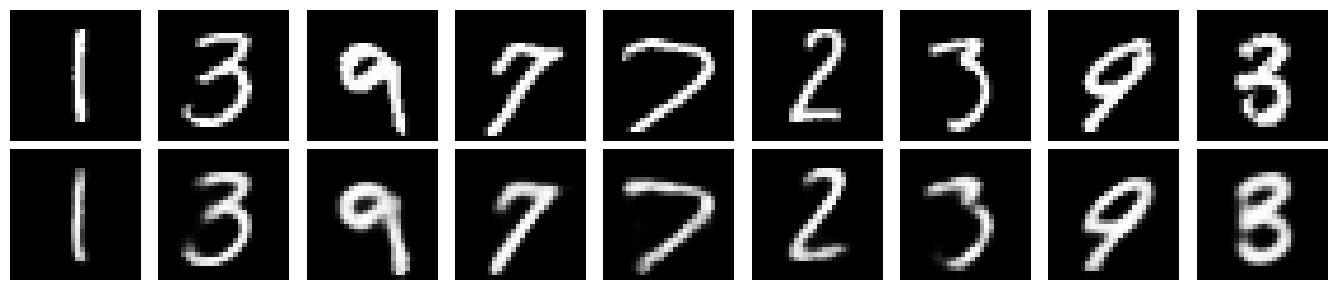

In [13]:
import matplotlib.pyplot as plt

originais, reconstrucoes = batch_to_plot # tupla com dois tensores

originais = originais.view(-1, 1, 28, 28)
reconstrucoes = reconstrucoes.view(-1, 1, 28, 28)

n = 9
fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
for i in range(n):
    axes[0, i].imshow(originais[i].squeeze(), cmap='gray', interpolation='none')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstrucoes[i].squeeze(), cmap='gray', interpolation='none')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

### Conclusão:

Ao longo da atividade, foram abordados conceitos fundamentais sobre autoencoders, usados para a construção da sua arquitetura e aplicação em dados reais, com um destaque nos autoencoders Variacionais, uma extensão dos autoencoders tradicionais que foram capazes de gerar novas amostras de dados a partir da distribuição latente aprendida, como observado no exemplo visual. 

A visualização das imagens reconstruídas permitiu validar qualitativamente o funcionamento do modelo, conseguimos observar que as reconstruções obtidas pela VAE preservaram as características principais das imagens originais, o que evidencia que nossa rede aprendeu uma representação significativa do espaço latente. Aplicamos a divergência de Kullback-Leibler e o truque de reparametrização como soluções para os problemas do balanceamento entre a qualidade da reconstrução e a regularização do espaço latente.

### Referências:"

[1] BERGMANN, Dave; STRYKER, Cole. What is an autoencoder? IBM, 2023. Disponível em: https://www.ibm.com/think/topics/autoencoder.

[2] IPPOLITO, Pier Paolo. Introduction to Autoencoders: From The Basics to Advanced Applications in PyTorch. Geeks for geeks, 2023. Disponível em: https://www.datacamp.com/tutorial/introduction-to-autoencoders.

[3] Variacional Autoencoders. Geeks for geeks, 2025. Disponível em: https://www.geeksforgeeks.org/variational-autoencoders/.

[4] NLP From Scratch: Translation with a Sequence to Sequence Network and Attention. Pytorch Tutorials, 2017. Disponível em: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#exercises.

[5] JONES, Llion. The reparameterization trick. Medium, 2017. Disponível em: https://medium.com/@llionj/the-reparameterization-trick-4ff30fe92954. 

[6] What is Adam Optimizer? Geeks for geeks, 2025. Disponível em: https://www.geeksforgeeks.org/adam-optimizer/.

[7] MOLINETE, Joana. Notebook 4.5 "Um momento, por favor!" Otimizador gradient descent with momentum, 2025.

[8] Many ways to plot images. Dcoumentação Matplotlib. Disponível em: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_demo.html.

[9] Create multiple subplots using plt.subplots. Documentação Matplotlib. Disponível em: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html.